In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [2]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)

  # long_dim = max(shape)
  # scale = max_dim / long_dim

  # new_shape = tf.cast(shape * scale, tf.int32)

  # img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)
print(vgg.get_layer(vgg.layers[0].name))
print(vgg.input)



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 300, 454, 3)


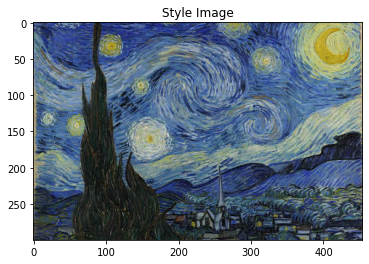

In [6]:
style_path = 'starrynight.jpg'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
style_image = load_img(style_path)
print(style_image.shape)
imshow(style_image, 'Style Image')

In [7]:
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Conv2D
def vgg_layers(layer_names,shape):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  sh=(shape[1],shape[2],shape[3])
  vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet',input_shape=sh)
  vgg.trainable = False  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  model.summary()
  return model

In [8]:
style_extractor = vgg_layers(style_layers,style_image.shape)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 454, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 454, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 454, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 227, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 227, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 227, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 113, 128)      0     

In [9]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [10]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers,shape):
    super(StyleModel, self).__init__()
    self.vgg = vgg_layers(style_layers,shape)
    self.style_layers = style_layers
    self.vgg.trainable = False
    self.shape=shape
    self.num_style_layers = len(style_layers)

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    
    preprocessed_input = tf.keras.applications.vgg16.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs = outputs
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    return style_dict

In [11]:
image = tf.Variable(np.random.randn(1,style_image.shape[1],style_image.shape[2],style_image.shape[3],))
shape=image.shape
extractor = StyleModel(style_layers, image.shape)

results = extractor(tf.constant(style_image))
print("Styles:")
for name, output in sorted(results.items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 454, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 454, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 454, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 227, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 227, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 227, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 113, 128)      0   

In [12]:
style_targets = extractor(style_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.02,
    decay_steps=100,
    decay_rate=0.9,
    staircase=True)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
total_variation_weight=10



In [13]:
def style_loss(outputs):
    
    style_outputs = outputs
    # print([((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    
    loss =  style_loss
    return loss

In [14]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_loss(outputs)
    # loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return loss

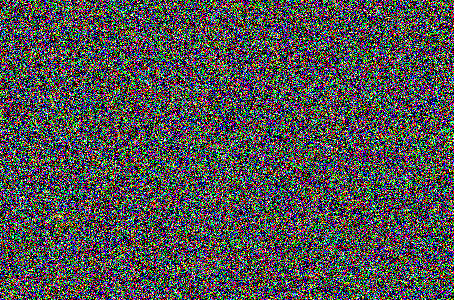

In [15]:

# print(image.shape)
train_step(image)
tensor_to_image(image)

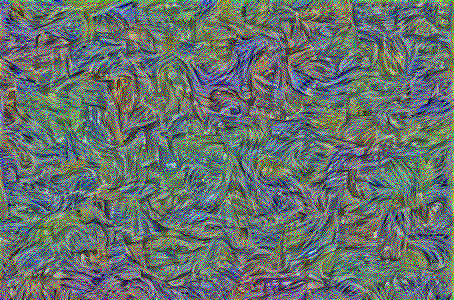

Train step: 2000
Total time: 180.2


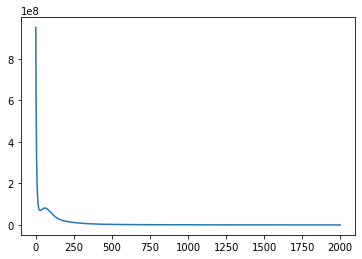

In [16]:
import time
import IPython.display as display

start = time.time()

epochs = 20
steps_per_epoch = 100
lossarr=[]
step = 0
for n in range(epochs):
  l=0
  for m in range(steps_per_epoch):
    step += 1
    l=train_step(image)
    lossarr.append(l)
    print(".", end='', flush=True)
  
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
plt.plot(lossarr)

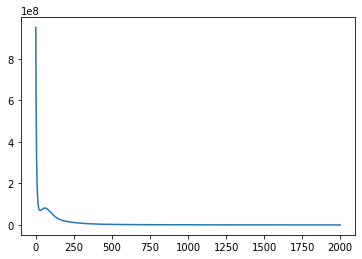

In [17]:
plt.plot(lossarr)

In [18]:
p=np.array([1,2,3,4,5,6,7,8,9])
p-2

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [19]:
tf.reduce_sum(lossarr[-200:-180]-lossarr[-180])

<tf.Tensor: shape=(), dtype=float32, numpy=56475.5>

In [20]:
tf.reduce_sum(lossarr[-100:-80]-lossarr[-80])

<tf.Tensor: shape=(), dtype=float32, numpy=49265.625>

In [21]:
tf.reduce_sum(lossarr[-400:-380]-lossarr[-380])

<tf.Tensor: shape=(), dtype=float32, numpy=75679.5>

In [22]:
tf.reduce_sum(lossarr[-20:-1]-lossarr[-1])

<tf.Tensor: shape=(), dtype=float32, numpy=43743.188>

In [23]:
tf.reduce_sum(lossarr[-800:-780]-lossarr[-780])

<tf.Tensor: shape=(), dtype=float32, numpy=155889.06>